<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (GRU)

###Install dependencies

In [5]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00


###Load Libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [51]:
import random as python_random
def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

###Define Functions to Facilitate Metrics Evaluation

In [52]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [119]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [120]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [121]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [122]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

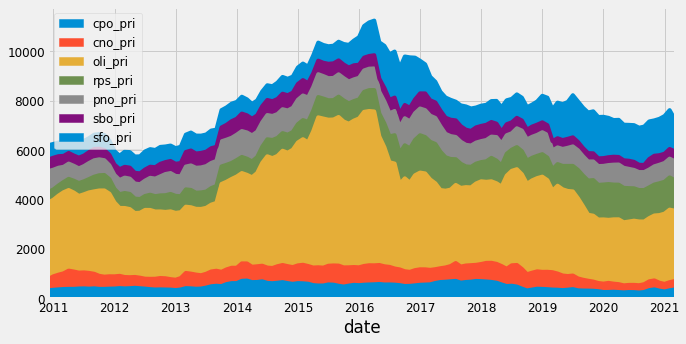

In [123]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (GRU)**

###**Split Data into Train Test Segments**

In [124]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [125]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [126]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [127]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [128]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [129]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [130]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [131]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [156]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [157]:
GRU_model = tf.keras.Sequential()
GRU_model.add(tf.keras.layers.GRU(85, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
GRU_model.add(tf.keras.layers.Dense(64, activation='tanh'))
GRU_model.add(tf.keras.layers.Dense(1))

# compile model using adam
GRU_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = GRU_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
GRU_model.evaluate(X_test, y_test)

Epoch 1/100
2/2 [==============================] - 3s 609ms/step - loss: 0.1851 - mse: 0.1851 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 2/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 3/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0607 - val_mse: 0.0607
Epoch 4/100
2/2 [==============================] - 0s 65ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0514 - val_mse: 0.0514
Epoch 5/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 7/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0555 - val_mse: 0.0555
Epoch 8/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0214 - mse: 0.0

[0.010921597480773926, 0.010921597480773926]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


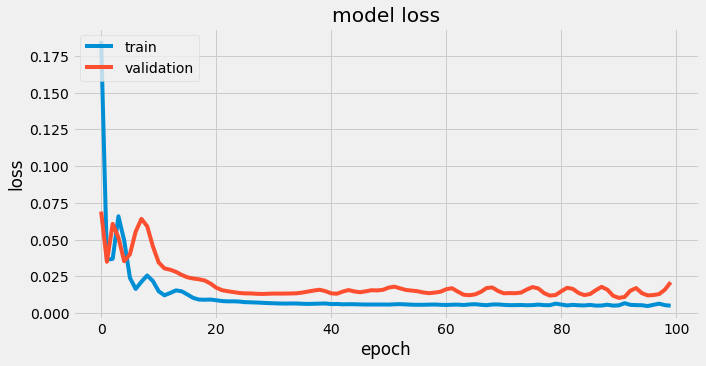

<Figure size 720x360 with 0 Axes>

In [158]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('TLV.png')

In [149]:
mse_GRU = GRU_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 29ms/step - loss: 0.0153 - mse: 0.0153


####Baseline MSE = 0.0096

In [136]:
GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 75)                18900     
                                                                 
 dense_6 (Dense)             (None, 64)                4864      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,829
Trainable params: 23,829
Non-trainable params: 0
_________________________________________________________________


###Predict the Test without Hyperparameter Tuning

In [137]:
y_pred = GRU_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 293ms/step


array([[ 0.08702145],
       [ 0.08798899],
       [ 0.11499961],
       [ 0.08041095],
       [ 0.05287081],
       [ 0.03372486],
       [ 0.02111699],
       [-0.00554089],
       [-0.05932294],
       [-0.08306941],
       [-0.07026087],
       [-0.07743108],
       [-0.09504978],
       [-0.08681139],
       [-0.09279322],
       [-0.12505771],
       [-0.12544152],
       [-0.00238361],
       [ 0.09431549],
       [ 0.06914759],
       [ 0.00929866],
       [ 0.02831345]], dtype=float32)

In [138]:
y_pred.reshape(1,-1)

array([[ 0.08702145,  0.08798899,  0.11499961,  0.08041095,  0.05287081,
         0.03372486,  0.02111699, -0.00554089, -0.05932294, -0.08306941,
        -0.07026087, -0.07743108, -0.09504978, -0.08681139, -0.09279322,
        -0.12505771, -0.12544152, -0.00238361,  0.09431549,  0.06914759,
         0.00929866,  0.02831345]], dtype=float32)

###Invert Transformed Data

In [139]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[353.80856 354.1956  364.99985 351.1644  340.14832 332.48993 327.4468
  316.78363 295.2708  285.77222 290.89566 288.0276  280.98007 284.27545
  281.88272 268.97693 268.8234  318.04654 356.7262  346.65903 322.71945
  330.32538]]


###Plot History, Actual and Predicted Value

In [140]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [141]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [142]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([353.80856, 354.1956 , 364.99985, 351.1644 , 340.14832, 332.48993,
       327.4468 , 316.78363, 295.2708 , 285.77222, 290.89566, 288.0276 ,
       280.98007, 284.27545, 281.88272, 268.97693, 268.8234 , 318.04654,
       356.7262 , 346.65903, 322.71945, 330.32538], dtype=float32)

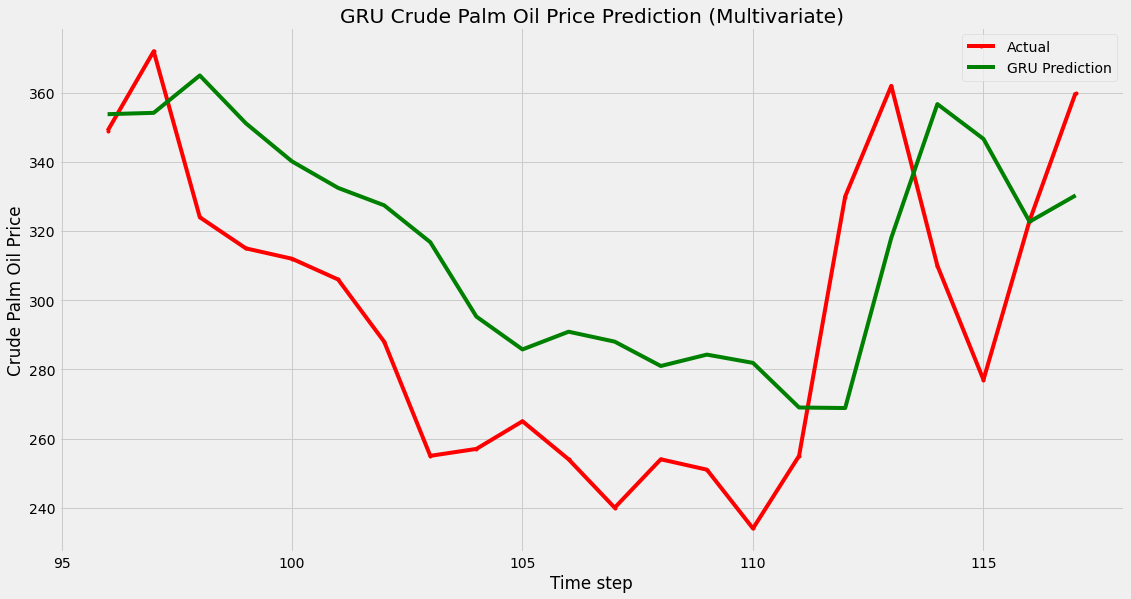

In [144]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="GRU Prediction")
plt.title("GRU Crude Palm Oil Price Prediction (Multivariate)")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
plt.savefig('graph_GRU.png')
#plt.grid()
#plt.show();

In [162]:
y_pred_inv

array([353.80856, 354.1956 , 364.99985, 351.1644 , 340.14832, 332.48993,
       327.4468 , 316.78363, 295.2708 , 285.77222, 290.89566, 288.0276 ,
       280.98007, 284.27545, 281.88272, 268.97693, 268.8234 , 318.04654,
       356.7262 , 346.65903, 322.71945, 330.32538], dtype=float32)

In [170]:
GRU = y_pred_inv 
df1=pd.DataFrame(GRU, columns=['GRU_Prediction']) 
print (df1)

    GRU_Prediction
0       353.808563
1       354.195587
2       364.999847
3       351.164398
4       340.148315
5       332.489929
6       327.446808
7       316.783630
8       295.270813
9       285.772217
10      290.895660
11      288.027588
12      280.980072
13      284.275452
14      281.882721
15      268.976929
16      268.823395
17      318.046539
18      356.726196
19      346.659027
20      322.719452
21      330.325378


In [177]:
#Save GRU prediction to csv file
df1.to_csv("GRU_Prediction.csv")

###Evaluate GRU Model Accuracy

In [78]:
MAE_GRU = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the GRU Model is:', MAE_GRU)

MDA_GRU = mda(y_test_inv, y_pred_inv)
print('MDA value of the GRU Model is:', MDA_GRU)

MAPE_GRU = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the GRU Model is:', MAPE_GRU)

RMSE_GRU = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the GRU Model is:', RMSE_GRU)

MSE_GRU = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the GRU Model is:', MSE_GRU)

#EVS_GRU = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the GRU Model is:', EVS_GRU)

MAE value of the GRU Model is: 40.975487448952414
MDA value of the GRU Model is: 0.6190476190476191
MAPE value of the GRU Model is: 14.602824801529612
RMSE value of the GRU Model is: 45.29646161299372
MSE value of the GRU Model is: 2051.7694346574135


###Tuning GRU with Keras Tuner

Define A Model-Building Class

In [79]:
#class ANNhypermodel(HyperModel):
class GRUHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        #hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        #hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        #model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        #model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = GRUHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [80]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [81]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [82]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 1s 1s/step - loss: 0.0511 - mae: 0.1861 - mse: 0.0511


####Random Search MSE = 0.0511

In [83]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 64,
 'dropout': 0.1,
 'optimizer': 'adagrad',
 'activation': 'ELU',
 'batch_size': 24,
 'epoch': 75,
 'momentum': 0.9700000000000001,
 'decay': 0.000500001,
 'learning_rate': 0.00014948684422968163}

###Build Bayesian Optimization

In [84]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [85]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 302ms/step - loss: 0.1467 - mae: 0.3637 - mse: 0.1467


###Bayesian Optimization Search MSE = 0.1467

###Evaluate Bayesian Optimization

In [86]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 128,
 'dropout': 0.25,
 'optimizer': 'adadelta',
 'activation': 'sigmoid',
 'batch_size': 24,
 'epoch': 40,
 'momentum': 0.8700000000000001,
 'decay': 0.00010000100000000001,
 'learning_rate': 0.001453129317743269}

In [87]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 305ms/step - loss: 0.1467 - mae: 0.3637 - mse: 0.1467


###Build HYPERBAND optimization

In [88]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [89]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [90]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1447.0631687641144  secs


###Hyperband MSE = 0.01193

In [92]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 


drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 160,
second layer is 96 


drop out is 0.35000000000000003
batch_size is 16
epoch is 95
optimizer is nadam
activation is linear

momentum is 0.93
decay is 0.000700001

#learning rate is 0.005469451505533658                                        

and the optimal learning rate for the optimizer
is 0.005469451505533658.

[]
1/1 [==============================] - 0s 478ms/step - loss: 0.0119 - mae: 0.0957 - mse: 0.0119
loss:0.011934570036828518 mae: 0.09570423513650894 mse: 0.011934570968151093


In [93]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 160, 'units_2': 96, 'dropout': 0.35000000000000003, 'optimizer': 'nadam', 'activation': 'linear', 'batch_size': 16, 'epoch': 95, 'momentum': 0.93, 'decay': 0.000700001, 'learning_rate': 0.005469451505533658, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0176'}


###Apply the trained parameters to the GRU

In [152]:
TUGRU_model = tf.keras.Sequential()
TUGRU_model.add(tf.keras.layers.GRU(160, activation='linear', input_shape=(X_test.shape[1], X_test.shape[2])))
TUGRU_model.add(tf.keras.layers.Dense(96, activation='linear'))
#TUGRU_model.add(layers.Dropout(0.35))

TUGRU_model.add(tf.keras.layers.Dense(48, activation='linear'))
#TUGRU_model.add(layers.Dropout(0.35))
#TUGRU_model.add(tf.keras.layers.Dense(16, 'tanh'))
#TUGRU_model.add(layers.Dropout(0.35))

#Output layer of model
TUGRU_model.add(tf.keras.layers.Dense(1))

In [153]:
TUGRU_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Nadam(learning_rate=0.0054), metrics= ['mae', 'mse'])
#TUGRU_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUGRU_model.fit(X_train, y_train, epochs=95, batch_size=16,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/95
5/5 [==============================] - 3s 77ms/step - loss: 0.5411 - mae: 0.6608 - mse: 0.5411 - val_loss: 0.0611 - val_mae: 0.2156 - val_mse: 0.0611
Epoch 2/95
5/5 [==============================] - 0s 21ms/step - loss: 0.0387 - mae: 0.1463 - mse: 0.0387 - val_loss: 0.0441 - val_mae: 0.1751 - val_mse: 0.0441
Epoch 3/95
5/5 [==============================] - 0s 24ms/step - loss: 0.0300 - mae: 0.1382 - mse: 0.0300 - val_loss: 0.0181 - val_mae: 0.1150 - val_mse: 0.0181
Epoch 4/95
5/5 [==============================] - 0s 18ms/step - loss: 0.0174 - mae: 0.1045 - mse: 0.0174 - val_loss: 0.0158 - val_mae: 0.0962 - val_mse: 0.0158
Epoch 5/95
5/5 [==============================] - 0s 21ms/step - loss: 0.0164 - mae: 0.1046 - mse: 0.0164 - val_loss: 0.0205 - val_mae: 0.1075 - val_mse: 0.0205
Epoch 6/95
5/5 [==============================] - 0s 22ms/step - loss: 0.0149 - mae: 0.1005 - mse: 0.0149 - val_loss: 0.0144 - val_mae: 0.0912 - val_mse: 0.0144
Epoch 7/95
5/5 [==================

Plot Model Loss

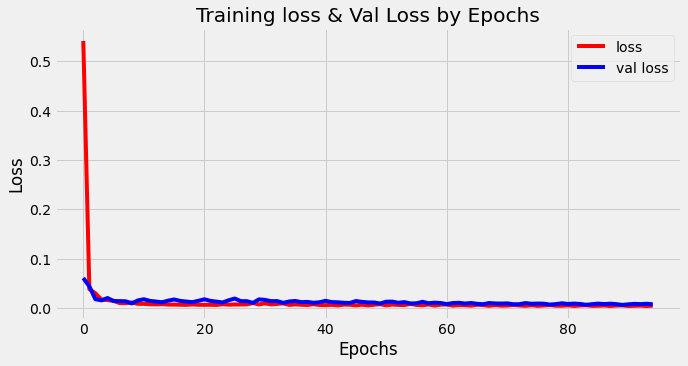

<Figure size 720x360 with 0 Axes>

In [154]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.savefig('OptTLV.png')

In [99]:
y_predTU = TUGRU_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 236ms/step


array([[ 4.6107493e-02],
       [ 5.7388116e-02],
       [ 9.6546784e-02],
       [ 5.4676086e-05],
       [-1.1077775e-02],
       [-2.2343714e-02],
       [-4.0800724e-02],
       [-9.4636649e-02],
       [-1.7590389e-01],
       [-1.8414673e-01],
       [-1.5936276e-01],
       [-1.7143460e-01],
       [-1.9409403e-01],
       [-1.5373334e-01],
       [-1.6159666e-01],
       [-2.1800807e-01],
       [-1.9117294e-01],
       [ 1.5981626e-03],
       [ 8.7964788e-02],
       [-2.8456923e-02],
       [-9.9525958e-02],
       [ 2.5059525e-03]], dtype=float32)

In [100]:
y_predTU.reshape(1,-1)

array([[ 4.6107493e-02,  5.7388116e-02,  9.6546784e-02,  5.4676086e-05,
        -1.1077775e-02, -2.2343714e-02, -4.0800724e-02, -9.4636649e-02,
        -1.7590389e-01, -1.8414673e-01, -1.5936276e-01, -1.7143460e-01,
        -1.9409403e-01, -1.5373334e-01, -1.6159666e-01, -2.1800807e-01,
        -1.9117294e-01,  1.5981626e-03,  8.7964788e-02, -2.8456923e-02,
        -9.9525958e-02,  2.5059525e-03]], dtype=float32)

###Invert Transformed Tuned Data

In [101]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[337.443   341.95526 357.6187  319.02188 314.5689  310.0625  302.67972
  281.14532 248.63844 245.34131 255.25488 250.42618 241.36238 257.50665
  254.36134 231.79677 242.53082 319.63925 354.1859  307.61725 279.1896
  320.00238]]


In [102]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [103]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [104]:
TU_GRU_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_GRU_Pred
TU_GRU_Pred

array([337.443  , 341.95526, 357.6187 , 319.02188, 314.5689 , 310.0625 ,
       302.67972, 281.14532, 248.63844, 245.34131, 255.25488, 250.42618,
       241.36238, 257.50665, 254.36134, 231.79677, 242.53082, 319.63925,
       354.1859 , 307.61725, 279.1896 , 320.00238], dtype=float32)

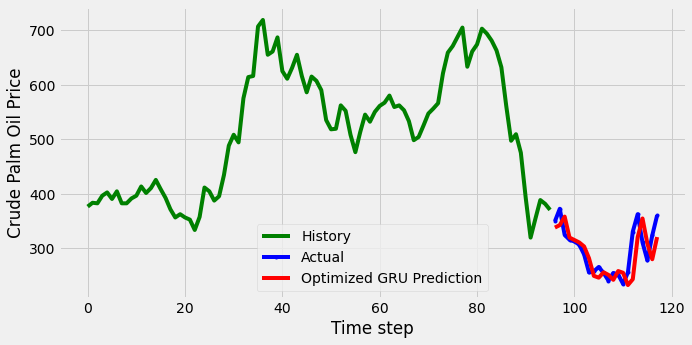

<Figure size 720x360 with 0 Axes>

In [150]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_GRU_Pred, color='red', label="Optimized GRU Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();
plt.savefig('GRUOpt.png')

### Optimized GRU Model Metric

In [106]:
TUMAE_GRU = mean_absolute_error(y_test_inv, TU_GRU_Pred)
print('MAE value of the GRU Model is:', TUMAE_GRU)

TUMDA_GRU = mda(y_test_inv, TU_GRU_Pred)
print('MDA value of the tuned GRU Model is:', TUMDA_GRU)

TUMAPE_GRU = mean_absolute_percentage_error(y_test_inv, TU_GRU_Pred)
print('MAPE value of the tuned GRU Model is:', TUMAPE_GRU)

TURMSE_GRU = mean_squared_error(y_test_inv,TU_GRU_Pred, squared=False)
print('RMSE value of the tuned GRU Model is:', TURMSE_GRU)

TUMSE_GRU = mean_squared_error(y_test_inv,TU_GRU_Pred)
print('MSE value of the tuned GRU Model is:', TUMSE_GRU)

MAE value of the GRU Model is: 23.525002219460227
MDA value of the tuned GRU Model is: 0.5714285714285714
MAPE value of the tuned GRU Model is: 7.709507454513364
RMSE value of the tuned GRU Model is: 30.65998310153814
MSE value of the tuned GRU Model is: 940.0345637866042


###Optimized GRU model prediction visualization

Comparing tuned GRU Actual VS Predicted (Zoomed-IN)

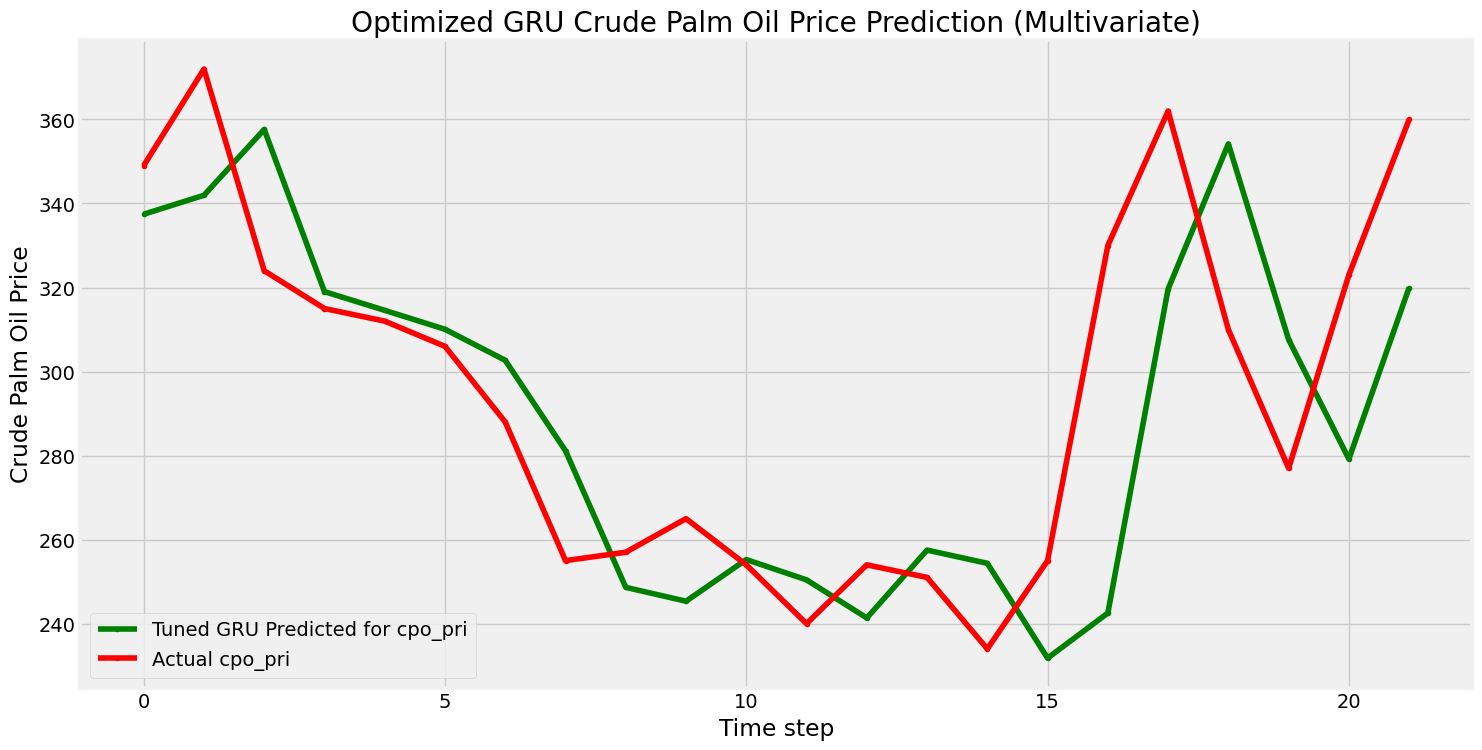

<Figure size 720x360 with 0 Axes>

In [108]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_GRU_Pred, color= 'green',marker='.',label = 'Tuned GRU Predicted - cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Optimized GRU Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUGRU.png')

###Comparing the optimized GRU, GRU, Bayesian and Random search models

* Baseline GRU MSE = 0.0153
* Random search MSE = 0.0511
* Bayesian search MSE = 0.1467
* Hyperband search MSE = 0.0119
* Baseline GRU RSME = 45.29
* Optimized GRU RSME = 30.65

The tuned GRU is superior to the basseline based on the RSME result

In [ ]:
'''
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}

    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
'''